In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
%cd ..

/home/daniel/Documents/attention_equivariant/equivariant-attention


In [2]:
from models import translation_attention, positional_encodings
import jax
from jax import numpy as jnp, random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib import colormaps

rngs = random.split(random.PRNGKey(seed=123), 10)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
d = 10
n_keys = 100
n_samples = 600


def f(x):
    return jnp.square(x) + jnp.mean(x)

def get_training_data(rng, n_samples, f):
    X_train = random.normal(rng, shape=[n_samples, d])
    X_train = X_train / jnp.linalg.norm(X_train, axis=-1)[:, None]
    Y_train = jax.vmap(f)(X_train)

    return X_train, Y_train

X_train, Y_train = get_training_data(rngs[0], n_samples, f)
X_test, Y_test = get_training_data(rngs[1], n_samples, f)

In [14]:
init_indices = random.choice(rngs[2], n_samples, shape=[n_keys], replace = False)
init_keys = X_train[init_indices] + (random.normal(rngs[3], shape=[n_keys, d]) * 0.01)
init_values = Y_train[init_indices]

fft_keys = jnp.fft.fft(jnp.flip(init_keys, axis = -1))
fft_values = jnp.fft.fft(jnp.flip(init_values, axis=-1))
beta = jnp.array(100.0)

In [15]:
n_epochs = 100

fft_keys_hist = jnp.zeros([n_epochs, n_keys, d], dtype=jnp.complex64)
fft_values_hist = jnp.zeros([n_epochs, n_keys, d], dtype=jnp.complex64)
beta_hist = jnp.zeros([n_epochs])

for e in tqdm(range(n_epochs)):
  fft_keys_hist = fft_keys_hist.at[e].set(fft_keys)
  fft_values_hist = fft_values_hist.at[e].set(fft_values)
  beta_hist = beta_hist.at[e].set(beta)
  [fft_keys, fft_values, beta] = translation_attention.update([fft_keys, fft_values, beta], X_train, Y_train, lr=1.0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
sampled_epochs = jnp.arange(0, n_epochs, int(n_epochs / 50))

train_loss_hist = jax.vmap(
    translation_attention.loss_ungrouped, in_axes=(None, None, 0, 0, 0)
)(
    X_train,
    Y_train,
    fft_keys_hist[sampled_epochs],
    fft_values_hist[sampled_epochs],
    beta_hist[sampled_epochs],
)
test_loss_hist = jax.vmap(
    translation_attention.loss_ungrouped, in_axes=(None, None, 0, 0, 0)
)(
    X_test,
    Y_test,
    fft_keys_hist[sampled_epochs],
    fft_values_hist[sampled_epochs],
    beta_hist[sampled_epochs],
)

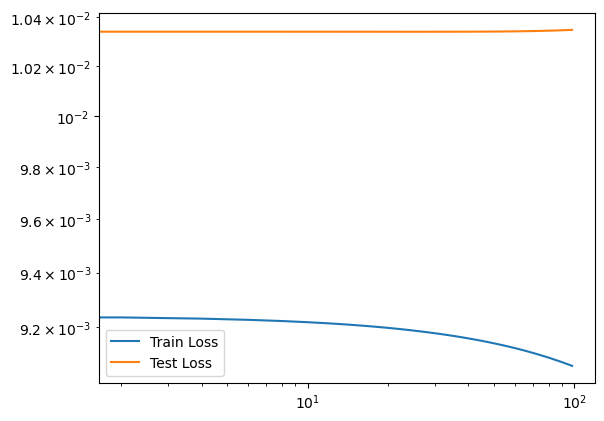

In [17]:
fig, ax = plt.subplots()

ax.plot(sampled_epochs, train_loss_hist, label ="Train Loss")
ax.plot(sampled_epochs, test_loss_hist, label ="Test Loss")

ax.set(xscale="log", yscale="log")
ax.legend()
plt.show()

In [18]:
test_pred = jnp.real(translation_attention.batched_call_fn(X_test, fft_keys_hist[-1], fft_values_hist[-1], beta_hist[-1]))
train_pred = jnp.real(translation_attention.batched_call_fn(X_train, fft_keys_hist[-1], fft_values_hist[-1], beta_hist[-1]))

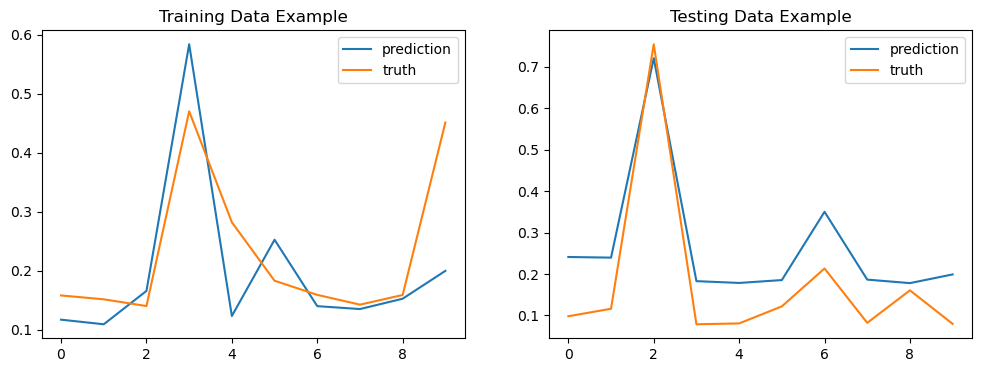

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
i = 7
axs[0].plot(train_pred[i], label="prediction")
axs[0].plot(Y_train[i], label="truth")


axs[1].plot(test_pred[i], label="prediction")
axs[1].plot(Y_test[i], label="truth")

axs[0].set(title="Training Data Example")
axs[1].set(title="Testing Data Example")

for ax in axs:
  ax.legend()

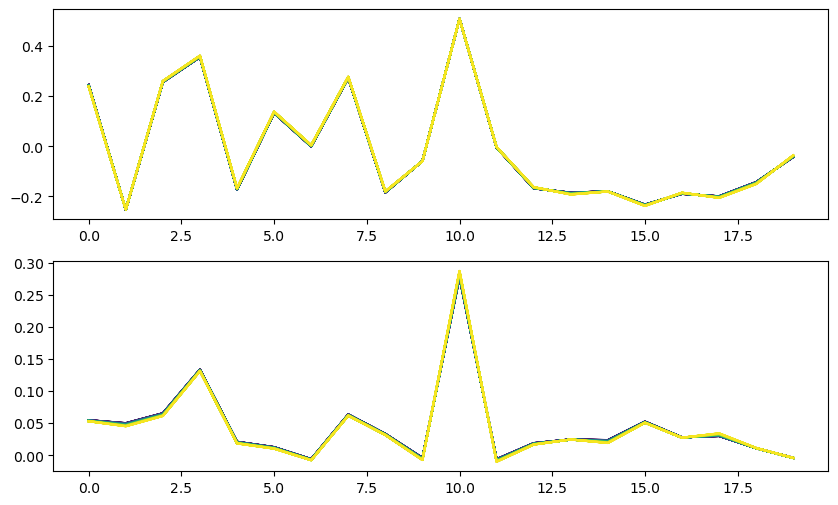

In [10]:
sampled_epochs = jnp.arange(0, n_epochs, int(n_epochs / 100))
i = 2

fig, axs = plt.subplots(2, 1, figsize = (10, 6))
cmap = colormaps.get_cmap('viridis')
for e in sampled_epochs:
  key = jnp.fft.ifft(fft_keys_hist[e, i, :])
  value = jnp.fft.ifft(fft_values_hist[e, i, :])
  axs[0].plot(jnp.real(key), color = cmap(e / n_epochs))
  axs[1].plot(jnp.real(value), color = cmap(e / n_epochs))
